In [50]:
import numpy as np

#高斯核 size*size
def gaussian_kernel(size, sigma=1):
    size = int(size)//2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1/(2.0*np.pi*sigma**2)
    g = np.exp(-((x**2+y**2)/(2.0*sigma**2)))*normal#离散化的二维高斯函数
    return g

In [ ]:
# np.mgrid的用法
size=2
x, y=np.mgrid[-size:size+1, -size:size+1]
print(x)
print(y)
print(x**2+y**2)

In [106]:
#rgb->gray， 这种转化方式实践效果好
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1],rgb[:,:,2]
    gray = 0.2989*r+0.5870*g+0.1140*b
    return gray

Text(0.5, 1.0, 'Smoothed')

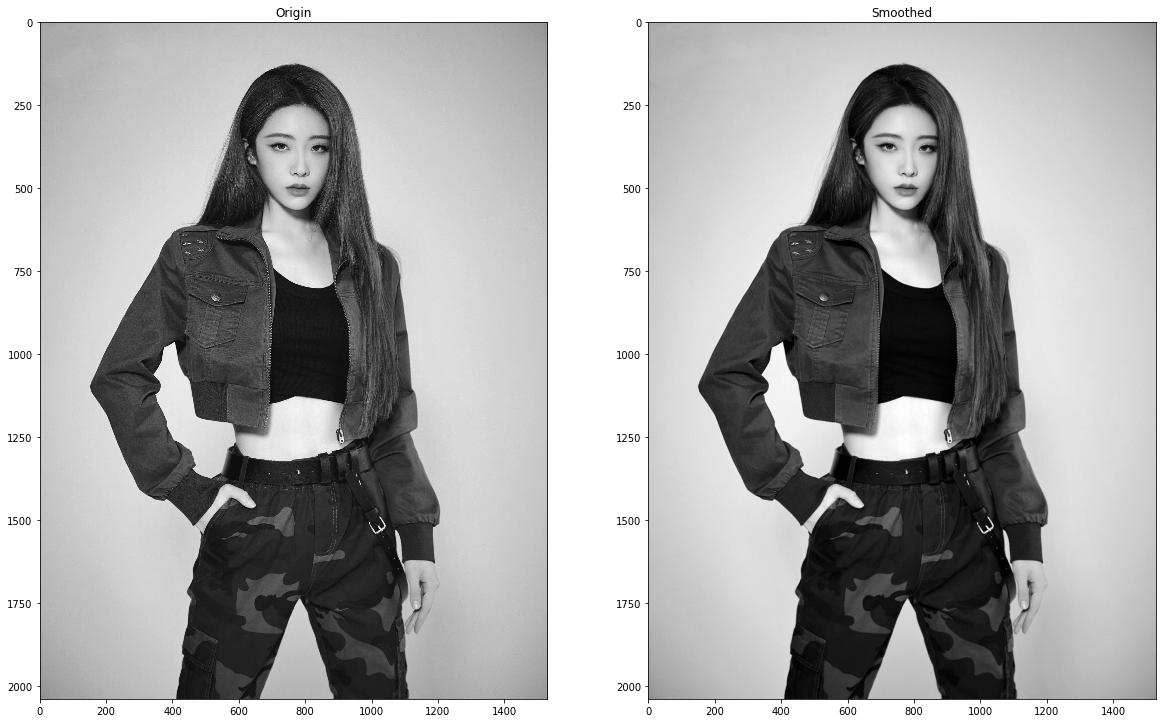

In [107]:
# 加载图片，并对其进行高斯模糊，然后输出对比图
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve

src=r"D:\_workPlace\Book\AI\CV\Canny边缘检测算法\originImg\4.jpg"
img = mpimg.imread(src)
img = rgb2gray(img)
# 由于程序输入的本就是灰度图，此步可略去
#if img.shape[0]==3:#即3通道的指示在第一个，正常的是在最后
#    img=img.transpose(1, 2, 0)# 改变img形状，使得3通道的指示变成最后一个，防止plt绘制的时候出错

# 高斯模糊
kernel_size = 5 # 5*5的卷积核
sigma=1
img_smoothed = convolve(img, gaussian_kernel(kernel_size, sigma))# 卷积

# 显示图片
plt.figure(figsize=(20, 40))
plt.subplot(1, 2, 1)# 行，列，第几个图
plt.imshow(img, "gray")
plt.title("Origin")
plt.subplot(122)
plt.imshow(img_smoothed, "gray")
plt.title("Smoothed")

In [ ]:
# 对rgb文件的试验
temp_src = r"C:\Users\MEC\Desktop\imgs\img-2266ac5a55bdf5f172321910af856ea8.jpg"
temp_img = mpimg.imread(temp_src)
print(temp_img.shape)
print(img.shape)
# 对比得到rgb会比灰度图多一维，3即3通道
if temp_img.shape[2]==3:
    temp_img=temp_img.transpose(1, 2, 0)
print(temp_img.shape)

In [110]:
#有点好看，存一下。设置cmap="gray"，存灰度图，否则会是有点绿的东西
#mpimg.imsave(r"C:\Users\MEC\Desktop\imgs\atmp.jpg", img_smoothed, cmap="gray")

In [111]:
# 肉眼看不出区别，代码对比一下
from skimage.measure import compare_ssim
import cv2
import imutils

(score, diff)=compare_ssim(img, img_smoothed, full=True)
diff = (diff*255).astype("uint8")
print(score)

#效果图有点不好看，注释掉
#thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
#cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#cnts = imutils.grab_contours(cnts)
#for c in cnts:
#    (x, y, w, h) = cv2.boundingRect(c)
#    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
#    cv2.rectangle(img_smoothed, (x, y), (x+w, y+h), (0, 0, 255), 2)
#plt.figure(figsize=(20, 40))
#plt.subplot(1, 2, 1)# 行，列，第几个图
#plt.imshow(img, "gray")
#plt.title("Origin")
#plt.subplot(122)
#plt.imshow(img_smoothed, "gray")
#plt.title("Smoothed")
#plt.show()

D:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


0.594135810218503


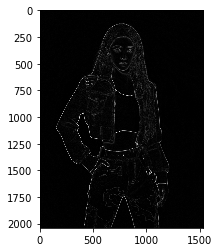

In [112]:
def sobel_filters(img):
    # 索贝尔算子
    Kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    # 偏导
    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)
    # 梯度幅值（因为梯度是个矢量，其大小称为幅值）和斜率
    G = np.hypot(Ix, Iy)# g=sqrt(Ix**2+Iy**2)
    G = G/G.max()*255 #修改范围
    G = G.astype(int)
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

gradientMat, thetaMat = sobel_filters(img_smoothed)
plt.imshow(gradientMat, "gray")

In [113]:
#非极大值抑制：通俗意义上是指寻找像素点局部最大值，将非极大值点所对应的灰度值置为0
#这样可以剔除掉一大部分非边缘的点
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = D*180./np.pi
    angle[angle<0]+=180
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q=255
                r=255
                #angle 0
                if (0<=angle[i, j]<22.5) or (157.5<=angle[i,j]<=180):
                    q=img[i, j+1]
                    r=img[i, j-1]
                #angle 45
                elif (22.5<=angle[i, j]<67.5):
                    q=img[i+1, j-1]
                    r=img[i-1, j+1]
                #angle 90
                elif (67.5<=angle[i,j]<112.5):
                    q=img[i+1, j]
                    r=img[i-1, j]
                #angle 135
                elif (112.5<=angle[i,j]<157.5):
                    q=img[i-1, j-1]
                    r=img[i+1,j+1]
                
                if img[i,j]>=q and img[i,j]>=r:
                    Z[i, j]=img[i,j]
                else:
                    Z[i, j]=0
            except IndexError as e:
                pass
    return Z

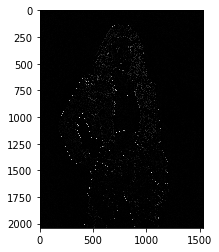

In [114]:
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
plt.imshow(nonMaxImg, "gray")
plt.show()

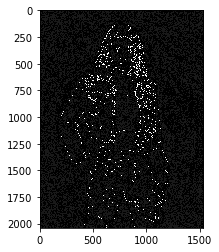

In [116]:
#双重门槛
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    highThreshold = int(img.max()*highThresholdRatio)
    lowThreshold = int(highThreshold*lowThresholdRatio)
    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)
    weak = np.int32(25)
    strong = np.int32(255)
    strong_i, strong_j = np.where(img>=highThreshold)
    zeros_i, zeros_j = np.where(img<lowThreshold)
    weak_i, weak_j = np.where((img<=highThreshold)&(img>=lowThreshold))
    
    res[strong_i, strong_j]=strong
    res[weak_i, weak_j]=weak
    
    return (res, weak, strong)

thresholdImg, weak, strong = threshold(nonMaxImg)
#print(thresholdImg)
plt.imshow(thresholdImg, "gray")

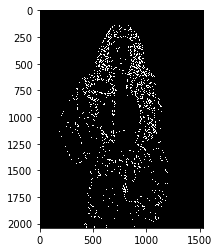

In [121]:
# 滞后边缘跟踪：基于阈值结果，滞后包括将弱像素转换为强像素，当且仅当正在处理的像素周围的像素中的至少一个像素是强像素时
def hysteresis(img, weak, strong=255):
    M, N=img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if img[i, j]==weak:
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i,j]=strong
                    else:
                        img[i,j]=0
                except IndexError as e:
                    pass
    return img

img_final = hysteresis(thresholdImg, weak, strong)
plt.imshow(img_final, "gray")

In [ ]:
#OVER